In [1]:
# import necessary libraries
import numpy as np 
import mediapipe as mp 
import os
import cv2
import keyboard
import tensorflow as tf


def make_folders(actions, no_sequences, DATA_PATH):

    for action in actions: 
        for frame_num in range(no_sequences):
            try: 
                os.makedirs(os.path.join(DATA_PATH, action, str(frame_num)))
            except:
                pass



def extract_keypoints(results, width, height):
    keypoint_values = []
    hand_no = 0

    if results.multi_hand_landmarks:
        for hand_no, handLandmarks in enumerate(results.multi_hand_landmarks):
            hand_no =+ 1
            for point in mp.solutions.hands.HandLandmark:
                normalizedLandmark = handLandmarks.landmark[point]
                pixelCoordinatesLandmark = mp.solutions.drawing_utils._normalized_to_pixel_coordinates(normalizedLandmark.x, normalizedLandmark.y, width, height)
                keypoint_values.append([normalizedLandmark.x, normalizedLandmark.y, handLandmarks.landmark[point].z])
                keypoint_array = np.array(keypoint_values)
                keypoint_array_flat = keypoint_array.flatten()
        
        if (hand_no == 1) and (len(keypoint_array_flat) < 126): 
            zero_array = np.zeros(63)
            if results.multi_handedness[0].classification[0].label == 'Right':
                keypoint_array_flat = np.append(keypoint_array_flat, zero_array)
            elif results.multi_handedness[0].classification[0].label == 'Left':
                keypoint_array_flat = np.append(zero_array, keypoint_array_flat)

        return (keypoint_array_flat)

def import_solutions():
    mp_hands = mp.solutions.hands
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles

    return(mp_hands, mp_drawing, mp_drawing_styles)


def frame_colection(key_action, key_to_press, count, input=0):
    
    mp_hands, mp_drawing, mp_drawing_styles = import_solutions()

    cap = cv2.VideoCapture(input)
    with mp_hands.Hands(
        static_image_mode = False,
        max_num_hands = 2,
        model_complexity=0,
        min_detection_confidence=0.3,
        min_tracking_confidence=0.7) as hands:

        while cap.isOpened():

            success, image = cap.read()

            if not success:
                cap.release()
                cv2.destroyAllWindows()
            else:

                if cv2.waitKey(25) & 0xFF == ord('q'):
                    break
                image.flags.writeable = False
                image = image
                cv2.imshow('frame', cv2.flip(image, 1))
                results = hands.process(image)
                image.flags.writeable = True

                if results.multi_hand_landmarks:
                    for hand_landmarks in results.multi_hand_landmarks:
                        mp_drawing.draw_landmarks(
                            image,
                            hand_landmarks,
                            mp_hands.HAND_CONNECTIONS,
                            mp_drawing_styles.get_default_hand_landmarks_style(),
                            mp_drawing_styles.get_default_hand_connections_style())
                cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))

                frameWidth = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
                frameHeight = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)

                sequence_length = 20
                DATA_PATH = os.path.join('MP_Data') 

                if keyboard.is_pressed(str(key_to_press)):
                    print('keyboard pressed: {}'.format(key_to_press))
                    for frame_num in range(sequence_length):
                        results = hands.process(image)
                        keypoints = extract_keypoints(results, frameWidth, frameHeight)
                        action = key_action[key_to_press]
                        npy_path = os.path.join(DATA_PATH, action, str(count), str(frame_num))
                        print(os.path.join(DATA_PATH, action, str(count), str(frame_num)))
                        cv2.imwrite(DATA_PATH+str(frame_num)+'.jpg', image)
                        np.save(npy_path, keypoints)
                        success, image = cap.read()
                        frame_num = frame_num +1
                        image.flags.writeable = False
                        image = image
                        cv2.imshow('frame', cv2.flip(image, 1))
                        results = hands.process(image)
                        image.flags.writeable = True

                        if results.multi_hand_landmarks:
                            for hand_landmarks in results.multi_hand_landmarks:
                                mp_drawing.draw_landmarks(
                                    image,
                                    hand_landmarks,
                                    mp_hands.HAND_CONNECTIONS,
                                    mp_drawing_styles.get_default_hand_landmarks_style(),
                                    mp_drawing_styles.get_default_hand_connections_style())
                        cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))

        cap.release()
        cv2.destroyAllWindows()


def make_variables(DATA_PATH, no_sequences, labels_dict, actions, sequence_length=10):
    
  
    sequences, labels = [], []
    for action in actions:
        for sequence in range(no_sequences):
            window = []
            for frame_num in range(sequence_length):
                res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)), allow_pickle=True)
                try:
               
                    window.append(list(res))
                except:
                    continue
            sequences.append(window)
            labels.append(labels_dict[action])

    return(sequences, labels)

def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame


def load_model(model_path):
    model = tf.keras.models.load_model(model_path)

    return(model)

In [2]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def show_cm(X, y, best_model):
    y_pred = best_model.predict(X)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)

    class_names = ['hola', 'a', 'b', 'c', 'i', 'n', 'bien']  # Reemplaza con los nombres reales de tus clases

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [3]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

DATA_PATH = os.path.join('MP_Data') 
actions = ['hola', 'a', 'b', 'c', 'i', 'n', 'bien']
no_sequences = 16
labels_dict = {label:num for num, label in enumerate(actions)}

sequences, labels = make_variables(DATA_PATH, no_sequences, labels_dict, actions)


In [4]:
np.asarray(sequences, dtype=object).shape

(112,)

In [5]:
# for seq, label in zip(sequences, labels):
#     print(len(seq))
#     for s in seq:
#         sequences_clean.append(s)
#         labels_clean.append(label)
# X = X.reshape((X.shape[0], 1, 126))

In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
# save as x and y variables 
sequences_clean, labels_clean = [], []

for seq, label in zip(sequences, labels):
    if len(seq) > 7:
        while len(seq) < 10:
            seq.append([0]*126)

        sequences_clean.append(seq[:7])
        labels_clean.append(label)

X = np.array(sequences_clean)
y = to_categorical(labels_clean).astype(int)

X, X_val, y, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

## allows to monitor accuracy while its training
# check on terminal- into Logs folder:  tensorboard --logdir=. 
# copy link 
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

learning_rate = 1e-4 
batch_size = 32
epochs = 400

steps_per_epoch = len(X) // batch_size
checkpoint_callback = ModelCheckpoint('my_model_manos16.keras', monitor='val_loss', save_best_only=True, mode='min')

optimizer = Adam(learning_rate=learning_rate)

model = Sequential()
# Long short-term memory 
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(7,126))) # returning sequences for next layer 
model.add(LSTM(128, return_sequences=True, activation='relu')) # returning sequences for next layer 
model.add(LSTM(64, return_sequences=False, activation='relu'))
# Dense layer: each neuron receives input from all the neurons of previous layer
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

# loss categorical_crossentropy because it is a multiclass classification
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(X, y, validation_data=(X_val, y_val), batch_size=batch_size, 
                    steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks=[tb_callback, checkpoint_callback])



Epoch 1/400


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - categorical_accuracy: 0.1562 - loss: 1.9454 - val_categorical_accuracy: 0.1875 - val_loss: 1.9422
Epoch 2/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.1250 - loss: 1.9451 - val_categorical_accuracy: 0.1875 - val_loss: 1.9421
Epoch 3/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.1771 - loss: 1.9446 - val_categorical_accuracy: 0.1250 - val_loss: 1.9420
Epoch 4/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.2083 - loss: 1.9453 - val_categorical_accuracy: 0.1250 - val_loss: 1.9418
Epoch 5/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.1979 - loss: 1.9442 - val_categorical_accuracy: 0.1875 - val_loss: 1.9415
Epoch 6/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.3750 - loss: 1.9440 - val_categorical_accuracy: 0.1875 - val_loss: 1.9414
Epoch 7/400
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.4062 - loss: 1.9426

2024-05-16 01:36:59.898840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-05-16 01:36:59.976739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:00.053439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3229 - loss: 1.9424 - val_categorical_accuracy: 0.1250 - val_loss: 1.9410
Epoch 8/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.1250 - loss: 1.9465 - val_categorical_accuracy: 0.1250 - val_loss: 1.9409
Epoch 9/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.2708 - loss: 1.9425 - val_categorical_accuracy: 0.1875 - val_loss: 1.9407
Epoch 10/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.2917 - loss: 1.9426 - val_categorical_accuracy: 0.1875 - val_loss: 1.9406
Epoch 11/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.2708 - loss: 1.9409 - val_categorical_accuracy: 0.2500 - val_loss: 1.9403
Epoch 12/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.2917 - loss: 1.9462 - val_categorical_accuracy: 0.2500 - val_loss: 1.9402
Epoch 13/400
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.3750 - loss: 1.9400

2024-05-16 01:37:00.131851: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:00.209564: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:00.289514: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.3438 - loss: 1.9409 - val_categorical_accuracy: 0.2500 - val_loss: 1.9400
Epoch 14/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.3333 - loss: 1.9432 - val_categorical_accuracy: 0.2500 - val_loss: 1.9399
Epoch 15/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3750 - loss: 1.9403 - val_categorical_accuracy: 0.2500 - val_loss: 1.9397
Epoch 16/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.2083 - loss: 1.9460 - val_categorical_accuracy: 0.2500 - val_loss: 1.9395
Epoch 17/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3750 - loss: 1.9408 - val_categorical_accuracy: 0.2500 - val_loss: 1.9393
Epoch 18/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.2500 - loss: 1.9429 - val_categorical_accuracy: 0.2500 - val_loss: 1.9391
Epoch 19/400


2024-05-16 01:37:00.371686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:00.453108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:00.533518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3438 - loss: 1.9406 - val_categorical_accuracy: 0.2500 - val_loss: 1.9387
Epoch 20/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.3333 - loss: 1.9393 - val_categorical_accuracy: 0.2500 - val_loss: 1.9385
Epoch 21/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.3333 - loss: 1.9399 - val_categorical_accuracy: 0.2500 - val_loss: 1.9381
Epoch 22/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.3333 - loss: 1.9415 - val_categorical_accuracy: 0.2500 - val_loss: 1.9379
Epoch 23/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3646 - loss: 1.9397 - val_categorical_accuracy: 0.2500 - val_loss: 1.9376
Epoch 24/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.3333 - loss: 1.9347 - val_categorical_accuracy: 0.2500 - val_loss: 1.9374
Epoch 25/400


2024-05-16 01:37:00.614444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:00.695643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:00.776457: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - categorical_accuracy: 0.4167 - loss: 1.9373 - val_categorical_accuracy: 0.3125 - val_loss: 1.9369
Epoch 26/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.2500 - loss: 1.9413 - val_categorical_accuracy: 0.2500 - val_loss: 1.9367
Epoch 27/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.4375 - loss: 1.9369 - val_categorical_accuracy: 0.2500 - val_loss: 1.9364
Epoch 28/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.2500 - loss: 1.9411 - val_categorical_accuracy: 0.2500 - val_loss: 1.9362
Epoch 29/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.3854 - loss: 1.9344 - val_categorical_accuracy: 0.2500 - val_loss: 1.9357
Epoch 30/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.3333 - loss: 1.9433 - val_categorical_accuracy: 0.2500 - val_loss: 1.9355
Epoch 31/400
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.2500 - loss: 1.9343

2024-05-16 01:37:00.858925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:00.937832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:01.017359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.3438 - loss: 1.9342 - val_categorical_accuracy: 0.2500 - val_loss: 1.9349
Epoch 32/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.3333 - loss: 1.9426 - val_categorical_accuracy: 0.2500 - val_loss: 1.9347
Epoch 33/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.3438 - loss: 1.9368 - val_categorical_accuracy: 0.2500 - val_loss: 1.9343
Epoch 34/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.5000 - loss: 1.9316 - val_categorical_accuracy: 0.2500 - val_loss: 1.9340
Epoch 35/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.3333 - loss: 1.9378 - val_categorical_accuracy: 0.2500 - val_loss: 1.9338
Epoch 36/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.3333 - loss: 1.9300 - val_categorical_accuracy: 0.2500 - val_loss: 1.9334
Epoch 37/400
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.3750 - loss: 1.9363

2024-05-16 01:37:01.099092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:01.176933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:01.253684: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.3854 - loss: 1.9339 - val_categorical_accuracy: 0.2500 - val_loss: 1.9327
Epoch 38/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - categorical_accuracy: 0.2917 - loss: 1.9365 - val_categorical_accuracy: 0.2500 - val_loss: 1.9322
Epoch 39/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.4583 - loss: 1.9288 - val_categorical_accuracy: 0.2500 - val_loss: 1.9313
Epoch 40/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.1667 - loss: 1.9468 - val_categorical_accuracy: 0.2500 - val_loss: 1.9309
Epoch 41/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.3646 - loss: 1.9330 - val_categorical_accuracy: 0.3125 - val_loss: 1.9301
Epoch 42/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.4167 - loss: 1.9271 - val_categorical_accuracy: 0.3125 - val_loss: 1.9297
Epoch 43/400


2024-05-16 01:37:01.332137: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:01.421769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:01.498858: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - categorical_accuracy: 0.3125 - loss: 1.9333 - val_categorical_accuracy: 0.3125 - val_loss: 1.9288
Epoch 44/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.4583 - loss: 1.9285 - val_categorical_accuracy: 0.3125 - val_loss: 1.9284
Epoch 45/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.4479 - loss: 1.9256 - val_categorical_accuracy: 0.2500 - val_loss: 1.9276
Epoch 46/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.1667 - loss: 1.9393 - val_categorical_accuracy: 0.2500 - val_loss: 1.9270
Epoch 47/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.4375 - loss: 1.9246 - val_categorical_accuracy: 0.2500 - val_loss: 1.9259
Epoch 48/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.1667 - loss: 1.9410 - val_categorical_accuracy: 0.2500 - val_loss: 1.9253
Epoch 49/400
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.3125 - loss: 1.9296

2024-05-16 01:37:01.577462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:01.657084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:01.736277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3646 - loss: 1.9256 - val_categorical_accuracy: 0.2500 - val_loss: 1.9240
Epoch 50/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.2917 - loss: 1.9297 - val_categorical_accuracy: 0.2500 - val_loss: 1.9233
Epoch 51/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.2812 - loss: 1.9277 - val_categorical_accuracy: 0.2500 - val_loss: 1.9220
Epoch 52/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.5000 - loss: 1.9164 - val_categorical_accuracy: 0.2500 - val_loss: 1.9213
Epoch 53/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.3646 - loss: 1.9257 - val_categorical_accuracy: 0.2500 - val_loss: 1.9198
Epoch 54/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.3333 - loss: 1.9141 - val_categorical_accuracy: 0.2500 - val_loss: 1.9190
Epoch 55/400
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.4062 - loss: 1.9117

2024-05-16 01:37:01.816665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:01.893611: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:01.970927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.3958 - loss: 1.9167 - val_categorical_accuracy: 0.2500 - val_loss: 1.9169
Epoch 56/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.3750 - loss: 1.9167 - val_categorical_accuracy: 0.2500 - val_loss: 1.9158
Epoch 57/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.4792 - loss: 1.9200 - val_categorical_accuracy: 0.2500 - val_loss: 1.9138
Epoch 58/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.2500 - loss: 1.9046 - val_categorical_accuracy: 0.2500 - val_loss: 1.9124
Epoch 59/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.4062 - loss: 1.9129 - val_categorical_accuracy: 0.3125 - val_loss: 1.9092
Epoch 60/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.4167 - loss: 1.9037 - val_categorical_accuracy: 0.3125 - val_loss: 1.9077
Epoch 61/400
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.2812 - loss: 1.9147

2024-05-16 01:37:02.047468: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:02.124242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:02.201202: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.3125 - loss: 1.9159 - val_categorical_accuracy: 0.3125 - val_loss: 1.9046
Epoch 62/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.5417 - loss: 1.8810 - val_categorical_accuracy: 0.3125 - val_loss: 1.9028
Epoch 63/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3854 - loss: 1.9022 - val_categorical_accuracy: 0.2500 - val_loss: 1.8989
Epoch 64/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.3750 - loss: 1.9129 - val_categorical_accuracy: 0.2500 - val_loss: 1.8968
Epoch 65/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3542 - loss: 1.9056 - val_categorical_accuracy: 0.3125 - val_loss: 1.8920
Epoch 66/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.4167 - loss: 1.8964 - val_categorical_accuracy: 0.2500 - val_loss: 1.8900
Epoch 67/400


2024-05-16 01:37:02.283563: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:02.365033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:02.445773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.4375 - loss: 1.8924 - val_categorical_accuracy: 0.2500 - val_loss: 1.8859
Epoch 68/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.2917 - loss: 1.8977 - val_categorical_accuracy: 0.2500 - val_loss: 1.8839
Epoch 69/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.3750 - loss: 1.8908 - val_categorical_accuracy: 0.2500 - val_loss: 1.8796
Epoch 70/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.3750 - loss: 1.9008 - val_categorical_accuracy: 0.2500 - val_loss: 1.8779
Epoch 71/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.4583 - loss: 1.8447 - val_categorical_accuracy: 0.2500 - val_loss: 1.8728
Epoch 72/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.2917 - loss: 1.9126 - val_categorical_accuracy: 0.2500 - val_loss: 1.8722
Epoch 73/400


2024-05-16 01:37:02.539700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:02.623448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:02.703861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.3438 - loss: 1.8535 - val_categorical_accuracy: 0.2500 - val_loss: 1.8699
Epoch 74/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.4583 - loss: 1.8421 - val_categorical_accuracy: 0.2500 - val_loss: 1.8697
Epoch 75/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - categorical_accuracy: 0.3333 - loss: 1.8479 - val_categorical_accuracy: 0.2500 - val_loss: 1.8685
Epoch 76/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.4167 - loss: 1.9125 - val_categorical_accuracy: 0.2500 - val_loss: 1.8680
Epoch 77/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.3854 - loss: 1.8149 - val_categorical_accuracy: 0.2500 - val_loss: 1.8698
Epoch 78/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.2500 - loss: 1.9295 - val_categorical_accuracy: 0.2500 - val_loss: 1.8682
Epoch 79/400
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - categorical_accuracy: 0.3750 - loss: 1.9180

2024-05-16 01:37:02.786135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:02.865278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:02.936488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3438 - loss: 1.9114 - val_categorical_accuracy: 0.2500 - val_loss: 1.8668
Epoch 80/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.3750 - loss: 1.6610 - val_categorical_accuracy: 0.2500 - val_loss: 1.8651
Epoch 81/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3021 - loss: 1.8839 - val_categorical_accuracy: 0.2500 - val_loss: 1.8621
Epoch 82/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.3750 - loss: 1.7195 - val_categorical_accuracy: 0.2500 - val_loss: 1.8615
Epoch 83/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.2917 - loss: 1.8365 - val_categorical_accuracy: 0.2500 - val_loss: 1.8618
Epoch 84/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.3333 - loss: 1.8716 - val_categorical_accuracy: 0.2500 - val_loss: 1.8640
Epoch 85/400
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.3750 - loss: 1.7895

2024-05-16 01:37:03.009494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:03.089953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:03.160484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.3438 - loss: 1.8064 - val_categorical_accuracy: 0.2500 - val_loss: 1.8746
Epoch 86/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.3333 - loss: 1.7888 - val_categorical_accuracy: 0.2500 - val_loss: 1.8769
Epoch 87/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.3021 - loss: 1.7796 - val_categorical_accuracy: 0.2500 - val_loss: 1.8753
Epoch 88/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.4583 - loss: 1.8388 - val_categorical_accuracy: 0.2500 - val_loss: 1.8786
Epoch 89/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.3021 - loss: 1.7819 - val_categorical_accuracy: 0.2500 - val_loss: 1.8807
Epoch 90/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.3750 - loss: 1.7608 - val_categorical_accuracy: 0.2500 - val_loss: 1.8862
Epoch 91/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.3333 - loss: 1.7411 - val_cate

2024-05-16 01:37:03.222346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:03.284169: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:03.346251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:03.407868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.3438 - loss: 1.7093 - val_categorical_accuracy: 0.2500 - val_loss: 1.9281
Epoch 94/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.2500 - loss: 1.8574 - val_categorical_accuracy: 0.2500 - val_loss: 1.9208
Epoch 95/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.3438 - loss: 1.6992 - val_categorical_accuracy: 0.2500 - val_loss: 1.9076
Epoch 96/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.3750 - loss: 1.6598 - val_categorical_accuracy: 0.3125 - val_loss: 1.9019
Epoch 97/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.3646 - loss: 1.7178 - val_categorical_accuracy: 0.3125 - val_loss: 1.9013
Epoch 98/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.3750 - loss: 1.5965 - val_categorical_accuracy: 0.3125 - val_loss: 1.9008
Epoch 99/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.2708 - loss: 1.8210 - val_cate

2024-05-16 01:37:03.472762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:03.534308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:03.596421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:03.660359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Epoch 101/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.3229 - loss: 1.6677 - val_categorical_accuracy: 0.3125 - val_loss: 1.8788
Epoch 102/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.4167 - loss: 1.5316 - val_categorical_accuracy: 0.3125 - val_loss: 1.8703
Epoch 103/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.2812 - loss: 1.6225 - val_categorical_accuracy: 0.3125 - val_loss: 1.8368
Epoch 104/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.5000 - loss: 1.5580 - val_categorical_accuracy: 0.3125 - val_loss: 1.8258
Epoch 105/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.3958 - loss: 1.4924 - val_categorical_accuracy: 0.3750 - val_loss: 1.8202
Epoch 106/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.2500 - loss: 1.7067 - val_categorical_accuracy: 0.3750 - val_loss: 1.7966
Epoch 107/400


2024-05-16 01:37:03.723663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:03.810243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:03.892658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.3646 - loss: 1.4837 - val_categorical_accuracy: 0.3125 - val_loss: 1.7822
Epoch 108/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.4167 - loss: 1.6735 - val_categorical_accuracy: 0.3750 - val_loss: 1.7333
Epoch 109/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.4583 - loss: 1.4363 - val_categorical_accuracy: 0.3125 - val_loss: 1.7207
Epoch 110/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.3333 - loss: 1.4956 - val_categorical_accuracy: 0.3125 - val_loss: 1.6978
Epoch 111/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.4792 - loss: 1.3932 - val_categorical_accuracy: 0.3750 - val_loss: 1.6602
Epoch 112/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - categorical_accuracy: 0.4583 - loss: 1.4311 - val_categorical_accuracy: 0.3750 - val_loss: 1.6585
Epoch 113/400


2024-05-16 01:37:03.975311: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:04.057438: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:04.139294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.5417 - loss: 1.3633 - val_categorical_accuracy: 0.3750 - val_loss: 1.6724
Epoch 114/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.4167 - loss: 1.4341 - val_categorical_accuracy: 0.3750 - val_loss: 1.6606
Epoch 115/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.4792 - loss: 1.3945 - val_categorical_accuracy: 0.3125 - val_loss: 1.7026
Epoch 116/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.3750 - loss: 1.3014 - val_categorical_accuracy: 0.3125 - val_loss: 1.6705
Epoch 117/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.5417 - loss: 1.2345 - val_categorical_accuracy: 0.2500 - val_loss: 1.6579
Epoch 118/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.5417 - loss: 1.4588 - val_categorical_accuracy: 0.2500 - val_loss: 1.6616
Epoch 119/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.6146 - loss: 1.2236 - va

2024-05-16 01:37:04.213140: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:04.275020: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:04.347170: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:04.410294: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.5833 - loss: 1.3091 - val_categorical_accuracy: 0.3125 - val_loss: 1.7045
Epoch 121/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.5417 - loss: 1.1783 - val_categorical_accuracy: 0.2500 - val_loss: 1.8378
Epoch 122/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.4583 - loss: 1.2700 - val_categorical_accuracy: 0.3750 - val_loss: 1.7785
Epoch 123/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.5521 - loss: 1.0779 - val_categorical_accuracy: 0.2500 - val_loss: 1.7429
Epoch 124/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.5000 - loss: 1.3701 - val_categorical_accuracy: 0.3125 - val_loss: 1.7492
Epoch 125/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.5833 - loss: 1.1391 - val_categorical_accuracy: 0.5000 - val_loss: 1.7928
Epoch 126/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.5417 - loss: 1.1291 - va

2024-05-16 01:37:04.473742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:04.536703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:04.599093: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:04.661531: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6250 - loss: 0.9317 - val_categorical_accuracy: 0.3750 - val_loss: 1.8502
Epoch 129/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.5104 - loss: 1.0802 - val_categorical_accuracy: 0.4375 - val_loss: 1.7694
Epoch 130/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6250 - loss: 0.9637 - val_categorical_accuracy: 0.4375 - val_loss: 1.7587
Epoch 131/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.5521 - loss: 1.0765 - val_categorical_accuracy: 0.3750 - val_loss: 1.7965
Epoch 132/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.5833 - loss: 0.8881 - val_categorical_accuracy: 0.4375 - val_loss: 1.8685
Epoch 133/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.6146 - loss: 0.9358 - val_categorical_accuracy: 0.5000 - val_loss: 2.1434
Epoch 134/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.5000 - loss: 1.2408 - va

2024-05-16 01:37:04.724523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:04.786803: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:04.850681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:04.914929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.7083 - loss: 0.8963 - val_categorical_accuracy: 0.4375 - val_loss: 1.9071
Epoch 137/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.6250 - loss: 0.9445 - val_categorical_accuracy: 0.4375 - val_loss: 1.9072
Epoch 138/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.4583 - loss: 1.0799 - val_categorical_accuracy: 0.3750 - val_loss: 1.9498
Epoch 139/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.5625 - loss: 0.9408 - val_categorical_accuracy: 0.3750 - val_loss: 2.0064
Epoch 140/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7083 - loss: 0.8058 - val_categorical_accuracy: 0.3750 - val_loss: 1.9385
Epoch 141/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.5729 - loss: 0.8863 - val_categorical_accuracy: 0.3750 - val_loss: 1.7571
Epoch 142/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7917 - loss: 0.9247 - va

2024-05-16 01:37:04.992659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:05.055264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:05.118493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:05.191034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6250 - loss: 0.8640 - val_categorical_accuracy: 0.2500 - val_loss: 1.6270
Epoch 145/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.7083 - loss: 0.8278 - val_categorical_accuracy: 0.3750 - val_loss: 1.8954
Epoch 146/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.6667 - loss: 0.8353 - val_categorical_accuracy: 0.5000 - val_loss: 2.0425
Epoch 147/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.5833 - loss: 0.9202 - val_categorical_accuracy: 0.3750 - val_loss: 1.6956
Epoch 148/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.5833 - loss: 0.7429 - val_categorical_accuracy: 0.4375 - val_loss: 1.6166
Epoch 149/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.5938 - loss: 0.8469 - val_categorical_accuracy: 0.4375 - val_loss: 1.5702
Epoch 150/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.7083 - loss: 0.7894 - va

2024-05-16 01:37:05.254571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:05.316873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:05.381388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:05.444937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.5417 - loss: 0.9947 - val_categorical_accuracy: 0.5000 - val_loss: 1.8189
Epoch 153/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.5833 - loss: 0.8900 - val_categorical_accuracy: 0.2500 - val_loss: 1.5544
Epoch 154/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7917 - loss: 0.6054 - val_categorical_accuracy: 0.3750 - val_loss: 1.6112
Epoch 155/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.6667 - loss: 0.8483 - val_categorical_accuracy: 0.3750 - val_loss: 1.7360
Epoch 156/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8333 - loss: 0.6553 - val_categorical_accuracy: 0.2500 - val_loss: 1.5754
Epoch 157/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.7188 - loss: 0.7531 - val_categorical_accuracy: 0.3125 - val_loss: 1.8841
Epoch 158/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.6250 - loss: 0.9015 - va

2024-05-16 01:37:05.517031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:05.580277: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:05.643885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:05.708530: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.6250 - loss: 1.1807 - val_categorical_accuracy: 0.5000 - val_loss: 1.9763
Epoch 161/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7604 - loss: 0.6978 - val_categorical_accuracy: 0.1875 - val_loss: 1.7154
Epoch 162/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.6250 - loss: 0.8084 - val_categorical_accuracy: 0.2500 - val_loss: 1.8631
Epoch 163/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.6875 - loss: 0.7827 - val_categorical_accuracy: 0.3750 - val_loss: 2.2821
Epoch 164/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.5000 - loss: 1.1536 - val_categorical_accuracy: 0.3125 - val_loss: 2.1227
Epoch 165/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.6875 - loss: 0.7725 - val_categorical_accuracy: 0.3750 - val_loss: 2.1079
Epoch 166/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7500 - loss: 0.7627 - va

2024-05-16 01:37:05.770927: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:05.830638: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:05.891553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:05.960562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.6667 - loss: 0.7840 - val_categorical_accuracy: 0.1875 - val_loss: 1.4603
Epoch 169/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8021 - loss: 0.7370 - val_categorical_accuracy: 0.3125 - val_loss: 1.6159
Epoch 170/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.6667 - loss: 0.6561 - val_categorical_accuracy: 0.3750 - val_loss: 1.7052
Epoch 171/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.6875 - loss: 0.6953 - val_categorical_accuracy: 0.5000 - val_loss: 1.5011
Epoch 172/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8333 - loss: 0.8411 - val_categorical_accuracy: 0.4375 - val_loss: 1.4602
Epoch 173/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - categorical_accuracy: 0.7917 - loss: 0.7363 - val_categorical_accuracy: 0.3750 - val_loss: 1.3143
Epoch 174/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7083 - loss: 0.6279 - va

2024-05-16 01:37:06.030529: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:06.090138: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:06.169859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:06.230350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7917 - loss: 0.7213 - val_categorical_accuracy: 0.4375 - val_loss: 1.5382
Epoch 177/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.6979 - loss: 0.6811 - val_categorical_accuracy: 0.3750 - val_loss: 1.4492
Epoch 178/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.6667 - loss: 0.6934 - val_categorical_accuracy: 0.4375 - val_loss: 1.3689
Epoch 179/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - categorical_accuracy: 0.7812 - loss: 0.6386 - val_categorical_accuracy: 0.5625 - val_loss: 1.2139
Epoch 180/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.7500 - loss: 0.6052 - val_categorical_accuracy: 0.5625 - val_loss: 1.2122
Epoch 181/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7917 - loss: 0.5915 - val_categorical_accuracy: 0.5000 - val_loss: 1.2489
Epoch 182/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.6667 - loss: 0.7456 - va

2024-05-16 01:37:06.291286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:06.362507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:06.433061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.6667 - loss: 0.6077 - val_categorical_accuracy: 0.5000 - val_loss: 1.4084
Epoch 185/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8125 - loss: 0.5900 - val_categorical_accuracy: 0.5000 - val_loss: 1.5119
Epoch 186/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7083 - loss: 0.6339 - val_categorical_accuracy: 0.4375 - val_loss: 1.4359
Epoch 187/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8333 - loss: 0.5342 - val_categorical_accuracy: 0.5000 - val_loss: 1.3060
Epoch 188/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.6667 - loss: 0.7685 - val_categorical_accuracy: 0.4375 - val_loss: 1.3086
Epoch 189/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8229 - loss: 0.5619 - val_categorical_accuracy: 0.3125 - val_loss: 1.3666
Epoch 190/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7500 - loss: 0.6661 - va

2024-05-16 01:37:06.493250: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:06.554429: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:06.615019: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:06.674854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7708 - loss: 0.5805 - val_categorical_accuracy: 0.5000 - val_loss: 1.6219
Epoch 192/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7917 - loss: 0.6355 - val_categorical_accuracy: 0.5000 - val_loss: 1.5384
Epoch 193/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7812 - loss: 0.5854 - val_categorical_accuracy: 0.5000 - val_loss: 1.2179
Epoch 194/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.7500 - loss: 0.6751 - val_categorical_accuracy: 0.5625 - val_loss: 1.1841
Epoch 195/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7396 - loss: 0.6007 - val_categorical_accuracy: 0.6250 - val_loss: 1.4459
Epoch 196/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7083 - loss: 0.6846 - val_categorical_accuracy: 0.6250 - val_loss: 1.4091
Epoch 197/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7500 - loss: 0.6265 - va

2024-05-16 01:37:06.734732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:06.794047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:06.864187: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:06.926223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.4332 - val_categorical_accuracy: 0.5000 - val_loss: 1.6123
Epoch 199/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7917 - loss: 0.5468 - val_categorical_accuracy: 0.4375 - val_loss: 1.7094
Epoch 200/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9583 - loss: 0.4149 - val_categorical_accuracy: 0.5000 - val_loss: 1.6830
Epoch 201/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7812 - loss: 0.5798 - val_categorical_accuracy: 0.4375 - val_loss: 1.7696
Epoch 202/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.8750 - loss: 0.5385 - val_categorical_accuracy: 0.4375 - val_loss: 1.5986
Epoch 203/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8333 - loss: 0.5324 - val_categorical_accuracy: 0.3750 - val_loss: 1.5112
Epoch 204/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7917 - loss: 0.5569 - va

2024-05-16 01:37:06.985906: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:07.046365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:07.107217: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:07.167796: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7917 - loss: 0.4684 - val_categorical_accuracy: 0.5625 - val_loss: 1.7707
Epoch 208/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7083 - loss: 0.7767 - val_categorical_accuracy: 0.5000 - val_loss: 1.8324
Epoch 209/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8021 - loss: 0.5236 - val_categorical_accuracy: 0.4375 - val_loss: 1.6152
Epoch 210/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7083 - loss: 0.5091 - val_categorical_accuracy: 0.3750 - val_loss: 1.3178
Epoch 211/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7604 - loss: 0.5802 - val_categorical_accuracy: 0.5625 - val_loss: 1.8850
Epoch 212/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7917 - loss: 0.4624 - val_categorical_accuracy: 0.5625 - val_loss: 1.9066
Epoch 213/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8125 - loss: 0.5466 - va

2024-05-16 01:37:07.229305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:07.291327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:07.351437: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:07.411678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - categorical_accuracy: 0.8646 - loss: 0.4703 - val_categorical_accuracy: 0.4375 - val_loss: 1.5012
Epoch 216/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.7083 - loss: 0.6098 - val_categorical_accuracy: 0.5625 - val_loss: 1.1276
Epoch 217/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7604 - loss: 0.5754 - val_categorical_accuracy: 0.5625 - val_loss: 1.3519
Epoch 218/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.4555 - val_categorical_accuracy: 0.5625 - val_loss: 1.3589
Epoch 219/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.7812 - loss: 0.5207 - val_categorical_accuracy: 0.5000 - val_loss: 1.6861
Epoch 220/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.4792 - val_categorical_accuracy: 0.5000 - val_loss: 1.7985
Epoch 221/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8542 - loss: 0.4814 - va

2024-05-16 01:37:07.477289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:07.547077: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:07.606854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:07.667499: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.4151 - val_categorical_accuracy: 0.5625 - val_loss: 1.4126
Epoch 223/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8438 - loss: 0.4572 - val_categorical_accuracy: 0.5625 - val_loss: 1.3649
Epoch 224/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.4873 - val_categorical_accuracy: 0.6250 - val_loss: 1.2977
Epoch 225/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8229 - loss: 0.4336 - val_categorical_accuracy: 0.4375 - val_loss: 1.5296
Epoch 226/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.6170 - val_categorical_accuracy: 0.4375 - val_loss: 1.5090
Epoch 227/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8229 - loss: 0.4678 - val_categorical_accuracy: 0.5000 - val_loss: 1.3602
Epoch 228/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.9583 - loss: 0.4074 - va

2024-05-16 01:37:07.728305: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:07.789404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:07.849726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:07.908748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8646 - loss: 0.4894 - val_categorical_accuracy: 0.5000 - val_loss: 1.7648
Epoch 232/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.8750 - loss: 0.2806 - val_categorical_accuracy: 0.4375 - val_loss: 1.6796
Epoch 233/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.9792 - loss: 0.3647 - val_categorical_accuracy: 0.5625 - val_loss: 1.4693
Epoch 234/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7083 - loss: 0.6836 - val_categorical_accuracy: 0.5000 - val_loss: 1.5071
Epoch 235/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - categorical_accuracy: 0.8750 - loss: 0.4086 - val_categorical_accuracy: 0.4375 - val_loss: 1.7928
Epoch 236/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8750 - loss: 0.4411 - val_categorical_accuracy: 0.4375 - val_loss: 1.7466
Epoch 237/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8958 - loss: 0.4133 - va

2024-05-16 01:37:07.968425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:08.028575: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:08.100560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:08.162951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.4269 - val_categorical_accuracy: 0.5625 - val_loss: 1.4019
Epoch 239/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8125 - loss: 0.4694 - val_categorical_accuracy: 0.5625 - val_loss: 1.3280
Epoch 240/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.3687 - val_categorical_accuracy: 0.5625 - val_loss: 1.3587
Epoch 241/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8854 - loss: 0.4053 - val_categorical_accuracy: 0.5625 - val_loss: 1.5315
Epoch 242/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.3571 - val_categorical_accuracy: 0.5000 - val_loss: 1.6556
Epoch 243/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.4451 - val_categorical_accuracy: 0.4375 - val_loss: 1.7739
Epoch 244/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.3427 - va

2024-05-16 01:37:08.222878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:08.283322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:08.343889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:08.404953: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8750 - loss: 0.4344 - val_categorical_accuracy: 0.5000 - val_loss: 2.1006
Epoch 248/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.6667 - loss: 0.6011 - val_categorical_accuracy: 0.4375 - val_loss: 1.6966
Epoch 249/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9062 - loss: 0.3443 - val_categorical_accuracy: 0.5625 - val_loss: 1.2251
Epoch 250/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.4125 - val_categorical_accuracy: 0.6250 - val_loss: 1.2508
Epoch 251/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8438 - loss: 0.4353 - val_categorical_accuracy: 0.5000 - val_loss: 1.2486
Epoch 252/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.3359 - val_categorical_accuracy: 0.4375 - val_loss: 1.7063
Epoch 253/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.4038 - va

2024-05-16 01:37:08.464782: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:08.525168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:08.585226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:08.644861: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8646 - loss: 0.4538 - val_categorical_accuracy: 0.5625 - val_loss: 1.4094
Epoch 256/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.4540 - val_categorical_accuracy: 0.5000 - val_loss: 1.1503
Epoch 257/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8438 - loss: 0.4702 - val_categorical_accuracy: 0.4375 - val_loss: 1.6141
Epoch 258/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - categorical_accuracy: 0.8333 - loss: 0.4552 - val_categorical_accuracy: 0.5000 - val_loss: 2.0969
Epoch 259/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.8125 - loss: 0.4580 - val_categorical_accuracy: 0.5625 - val_loss: 2.1120
Epoch 260/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.3718 - val_categorical_accuracy: 0.5625 - val_loss: 1.7441
Epoch 261/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9062 - loss: 0.3027 - va

2024-05-16 01:37:08.704648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:08.769895: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:08.835414: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:08.896868: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.5147 - val_categorical_accuracy: 0.5625 - val_loss: 1.1831
Epoch 263/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8021 - loss: 0.4510 - val_categorical_accuracy: 0.5000 - val_loss: 1.3593
Epoch 264/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.2644 - val_categorical_accuracy: 0.4375 - val_loss: 1.4951
Epoch 265/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.3769 - val_categorical_accuracy: 0.5000 - val_loss: 1.7621
Epoch 266/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.3293 - val_categorical_accuracy: 0.5625 - val_loss: 1.6620
Epoch 267/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8958 - loss: 0.3763 - val_categorical_accuracy: 0.5625 - val_loss: 1.3628
Epoch 268/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.3779 - va

2024-05-16 01:37:08.959270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.018354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.077683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.138984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.3511 - val_categorical_accuracy: 0.4375 - val_loss: 1.4547
Epoch 272/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.2915 - val_categorical_accuracy: 0.5000 - val_loss: 1.3839
Epoch 273/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8750 - loss: 0.3471 - val_categorical_accuracy: 0.4375 - val_loss: 1.4000
Epoch 274/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9583 - loss: 0.2776 - val_categorical_accuracy: 0.5000 - val_loss: 1.4252
Epoch 275/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8958 - loss: 0.3175 - val_categorical_accuracy: 0.5000 - val_loss: 1.4837
Epoch 276/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8750 - loss: 0.3380 - val_categorical_accuracy: 0.4375 - val_loss: 1.5682
Epoch 277/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.9062 - loss: 0.3082 - va

2024-05-16 01:37:09.197979: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.256772: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.316555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.380006: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.3306 - val_categorical_accuracy: 0.4375 - val_loss: 1.8141
Epoch 280/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.3407 - val_categorical_accuracy: 0.4375 - val_loss: 1.9495
Epoch 281/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9271 - loss: 0.3037 - val_categorical_accuracy: 0.5000 - val_loss: 2.1860
Epoch 282/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.4219 - val_categorical_accuracy: 0.5000 - val_loss: 1.9024
Epoch 283/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8750 - loss: 0.3234 - val_categorical_accuracy: 0.5625 - val_loss: 1.6508
Epoch 284/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9583 - loss: 0.2941 - val_categorical_accuracy: 0.6250 - val_loss: 1.5727
Epoch 285/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.3098 - va

2024-05-16 01:37:09.441550: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.499642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.560504: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.620674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9167 - loss: 0.3102 - val_categorical_accuracy: 0.5625 - val_loss: 1.9030
Epoch 288/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.3676 - val_categorical_accuracy: 0.5000 - val_loss: 1.8225
Epoch 289/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8750 - loss: 0.3256 - val_categorical_accuracy: 0.5625 - val_loss: 1.7349
Epoch 290/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 1.0000 - loss: 0.2183 - val_categorical_accuracy: 0.5000 - val_loss: 1.5438
Epoch 291/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8646 - loss: 0.3144 - val_categorical_accuracy: 0.4375 - val_loss: 1.4706
Epoch 292/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.3502 - val_categorical_accuracy: 0.5000 - val_loss: 1.7054
Epoch 293/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9167 - loss: 0.2684 - va

2024-05-16 01:37:09.680903: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.740233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.799674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.861573: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.2931 - val_categorical_accuracy: 0.4375 - val_loss: 1.1967
Epoch 296/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.9167 - loss: 0.2262 - val_categorical_accuracy: 0.5000 - val_loss: 1.0691
Epoch 297/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8750 - loss: 0.3418 - val_categorical_accuracy: 0.5000 - val_loss: 1.7990
Epoch 298/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.2216 - val_categorical_accuracy: 0.5625 - val_loss: 2.1203
Epoch 299/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8646 - loss: 0.3399 - val_categorical_accuracy: 0.5000 - val_loss: 2.0536
Epoch 300/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.2598 - val_categorical_accuracy: 0.5000 - val_loss: 1.9190
Epoch 301/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9375 - loss: 0.2363 - va

2024-05-16 01:37:09.921888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:09.990574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:10.050044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:10.108620: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9271 - loss: 0.2118 - val_categorical_accuracy: 0.5000 - val_loss: 1.9945
Epoch 304/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7083 - loss: 0.4334 - val_categorical_accuracy: 0.4375 - val_loss: 2.2384
Epoch 305/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.2435 - val_categorical_accuracy: 0.5000 - val_loss: 2.2957
Epoch 306/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.3499 - val_categorical_accuracy: 0.5000 - val_loss: 1.8643
Epoch 307/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8958 - loss: 0.3466 - val_categorical_accuracy: 0.3750 - val_loss: 1.4986
Epoch 308/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8750 - loss: 0.3403 - val_categorical_accuracy: 0.5000 - val_loss: 2.1047
Epoch 309/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8646 - loss: 0.3214 - va

2024-05-16 01:37:10.167157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:10.227487: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:10.288157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:10.349822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9062 - loss: 0.2805 - val_categorical_accuracy: 0.5000 - val_loss: 1.6252
Epoch 312/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.4333 - val_categorical_accuracy: 0.4375 - val_loss: 1.7211
Epoch 313/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8750 - loss: 0.3345 - val_categorical_accuracy: 0.5625 - val_loss: 2.7333
Epoch 314/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8750 - loss: 0.4762 - val_categorical_accuracy: 0.5625 - val_loss: 2.8347
Epoch 315/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8125 - loss: 0.3688 - val_categorical_accuracy: 0.5000 - val_loss: 1.9720
Epoch 316/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.2706 - val_categorical_accuracy: 0.4375 - val_loss: 1.5116
Epoch 317/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8542 - loss: 0.3946 - va

2024-05-16 01:37:10.409703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:10.469347: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:10.531185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:10.591234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8646 - loss: 0.3233 - val_categorical_accuracy: 0.5000 - val_loss: 2.2989
Epoch 320/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.3738 - val_categorical_accuracy: 0.5000 - val_loss: 2.2916
Epoch 321/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8021 - loss: 0.4114 - val_categorical_accuracy: 0.5000 - val_loss: 2.2118
Epoch 322/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.3013 - val_categorical_accuracy: 0.5000 - val_loss: 2.4541
Epoch 323/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8125 - loss: 0.3747 - val_categorical_accuracy: 0.4375 - val_loss: 2.4748
Epoch 324/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.2464 - val_categorical_accuracy: 0.3125 - val_loss: 2.4108
Epoch 325/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8542 - loss: 0.3852 - va

2024-05-16 01:37:10.651171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:10.711634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:10.771822: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:10.832229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.9271 - loss: 0.2850 - val_categorical_accuracy: 0.5000 - val_loss: 1.8327
Epoch 328/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9583 - loss: 0.2436 - val_categorical_accuracy: 0.4375 - val_loss: 1.9035
Epoch 329/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.2662 - val_categorical_accuracy: 0.4375 - val_loss: 1.8841
Epoch 330/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.2758 - val_categorical_accuracy: 0.5000 - val_loss: 1.8572
Epoch 331/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8854 - loss: 0.2901 - val_categorical_accuracy: 0.6250 - val_loss: 2.0390
Epoch 332/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.2993 - val_categorical_accuracy: 0.5000 - val_loss: 2.1205
Epoch 333/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - categorical_accuracy: 0.8750 - loss: 0.2734 - va

2024-05-16 01:37:10.893454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:10.953120: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.013121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.073812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9688 - loss: 0.2184 - val_categorical_accuracy: 0.4375 - val_loss: 2.1809
Epoch 336/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7917 - loss: 0.4274 - val_categorical_accuracy: 0.4375 - val_loss: 2.0133
Epoch 337/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9062 - loss: 0.2627 - val_categorical_accuracy: 0.5625 - val_loss: 1.9774
Epoch 338/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.2262 - val_categorical_accuracy: 0.5000 - val_loss: 1.9898
Epoch 339/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.8750 - loss: 0.3090 - val_categorical_accuracy: 0.5000 - val_loss: 2.3572
Epoch 340/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 1.0000 - loss: 0.1488 - val_categorical_accuracy: 0.5000 - val_loss: 2.2452
Epoch 341/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9167 - loss: 0.2674 - va

2024-05-16 01:37:11.133059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.193466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.254658: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.313993: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9271 - loss: 0.2588 - val_categorical_accuracy: 0.5625 - val_loss: 1.7767
Epoch 344/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 1.0000 - loss: 0.2164 - val_categorical_accuracy: 0.4375 - val_loss: 1.7634
Epoch 345/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9167 - loss: 0.2506 - val_categorical_accuracy: 0.3750 - val_loss: 2.1235
Epoch 346/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.2493 - val_categorical_accuracy: 0.3750 - val_loss: 2.0868
Epoch 347/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9375 - loss: 0.2347 - val_categorical_accuracy: 0.4375 - val_loss: 1.8624
Epoch 348/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.2410 - val_categorical_accuracy: 0.4375 - val_loss: 1.8084
Epoch 349/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9167 - loss: 0.2186 - va

2024-05-16 01:37:11.374034: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.434448: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.494219: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.552650: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9167 - loss: 0.2300 - val_categorical_accuracy: 0.4375 - val_loss: 2.2710
Epoch 352/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - categorical_accuracy: 0.8750 - loss: 0.3037 - val_categorical_accuracy: 0.3750 - val_loss: 1.9398
Epoch 353/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8958 - loss: 0.2458 - val_categorical_accuracy: 0.6250 - val_loss: 1.9227
Epoch 354/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9583 - loss: 0.2013 - val_categorical_accuracy: 0.6250 - val_loss: 1.8974
Epoch 355/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9479 - loss: 0.2208 - val_categorical_accuracy: 0.4375 - val_loss: 1.8926
Epoch 356/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.2723 - val_categorical_accuracy: 0.4375 - val_loss: 2.1522
Epoch 357/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.2793 - va

2024-05-16 01:37:11.612586: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.672937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.732757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.792315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9271 - loss: 0.2577 - val_categorical_accuracy: 0.4375 - val_loss: 1.8182
Epoch 360/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.1322 - val_categorical_accuracy: 0.4375 - val_loss: 1.8395
Epoch 361/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9375 - loss: 0.2049 - val_categorical_accuracy: 0.4375 - val_loss: 2.0030
Epoch 362/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - categorical_accuracy: 0.9167 - loss: 0.2348 - val_categorical_accuracy: 0.4375 - val_loss: 2.0969
Epoch 363/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9167 - loss: 0.2047 - val_categorical_accuracy: 0.5625 - val_loss: 1.9524
Epoch 364/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.3313 - val_categorical_accuracy: 0.5625 - val_loss: 1.9646
Epoch 365/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.9062 - loss: 0.2232 - va

2024-05-16 01:37:11.852061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.911661: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:11.971072: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:12.031857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9479 - loss: 0.1905 - val_categorical_accuracy: 0.4375 - val_loss: 2.2741
Epoch 368/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.2329 - val_categorical_accuracy: 0.4375 - val_loss: 2.2460
Epoch 369/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.1919 - val_categorical_accuracy: 0.4375 - val_loss: 2.1009
Epoch 370/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9583 - loss: 0.2196 - val_categorical_accuracy: 0.5000 - val_loss: 2.1133
Epoch 371/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9479 - loss: 0.1657 - val_categorical_accuracy: 0.5000 - val_loss: 2.1909
Epoch 372/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.3390 - val_categorical_accuracy: 0.4375 - val_loss: 2.3560
Epoch 373/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9583 - loss: 0.2078 - va

2024-05-16 01:37:12.091553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:12.150709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:12.211752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:12.271451: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.9375 - loss: 0.1898 - val_categorical_accuracy: 0.4375 - val_loss: 2.4696
Epoch 376/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9167 - loss: 0.1999 - val_categorical_accuracy: 0.4375 - val_loss: 2.3764
Epoch 377/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9375 - loss: 0.1848 - val_categorical_accuracy: 0.4375 - val_loss: 2.2359
Epoch 378/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9583 - loss: 0.2082 - val_categorical_accuracy: 0.3750 - val_loss: 2.2899
Epoch 379/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9479 - loss: 0.1850 - val_categorical_accuracy: 0.4375 - val_loss: 2.3954
Epoch 380/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.7917 - loss: 0.3739 - val_categorical_accuracy: 0.4375 - val_loss: 2.1941
Epoch 381/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9375 - loss: 0.2026 - va

2024-05-16 01:37:12.331859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:12.392076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:12.451678: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:12.510833: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8958 - loss: 0.3365 - val_categorical_accuracy: 0.4375 - val_loss: 2.5175
Epoch 384/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9583 - loss: 0.1555 - val_categorical_accuracy: 0.5000 - val_loss: 1.7826
Epoch 385/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.2446 - val_categorical_accuracy: 0.5625 - val_loss: 2.4525
Epoch 386/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8333 - loss: 0.2974 - val_categorical_accuracy: 0.6250 - val_loss: 2.9186
Epoch 387/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8229 - loss: 0.2673 - val_categorical_accuracy: 0.5625 - val_loss: 3.2624
Epoch 388/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9583 - loss: 0.1950 - val_categorical_accuracy: 0.5000 - val_loss: 2.7675
Epoch 389/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8750 - loss: 0.2330 - va

2024-05-16 01:37:12.570693: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:12.631850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:12.690477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:12.750055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.9271 - loss: 0.2251 - val_categorical_accuracy: 0.5000 - val_loss: 1.9826
Epoch 392/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.9167 - loss: 0.1494 - val_categorical_accuracy: 0.5000 - val_loss: 2.5987
Epoch 393/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - categorical_accuracy: 0.9167 - loss: 0.2082 - val_categorical_accuracy: 0.5625 - val_loss: 3.2917
Epoch 394/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 1.0000 - loss: 0.1066 - val_categorical_accuracy: 0.5625 - val_loss: 3.2423
Epoch 395/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9167 - loss: 0.2102 - val_categorical_accuracy: 0.5000 - val_loss: 2.5840
Epoch 396/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.8750 - loss: 0.2481 - val_categorical_accuracy: 0.4375 - val_loss: 2.2487
Epoch 397/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.9062 - loss: 0.2174 - va

2024-05-16 01:37:12.812818: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:12.878952: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:12.940522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-16 01:37:13.001367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 1.0000 - loss: 0.1292 - val_categorical_accuracy: 0.5625 - val_loss: 2.4614
Epoch 399/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - categorical_accuracy: 0.8854 - loss: 0.2265 - val_categorical_accuracy: 0.4375 - val_loss: 2.3984
Epoch 400/400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - categorical_accuracy: 0.9583 - loss: 0.1519 - val_categorical_accuracy: 0.4375 - val_loss: 2.5368


2024-05-16 01:37:13.061747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


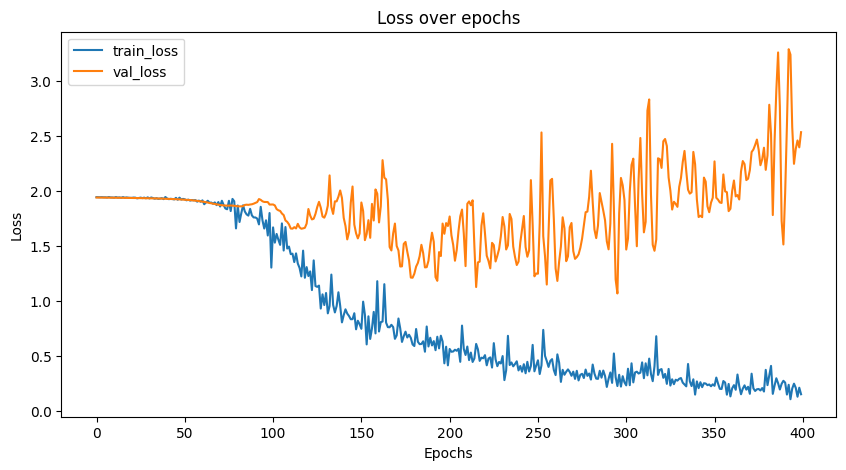

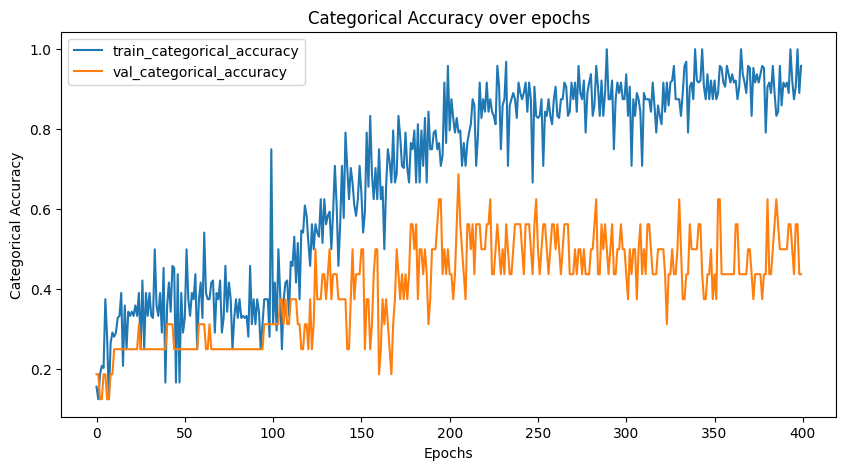

In [7]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='train_categorical_accuracy')
plt.plot(val_acc, label='val_categorical_accuracy')
plt.title('Categorical Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


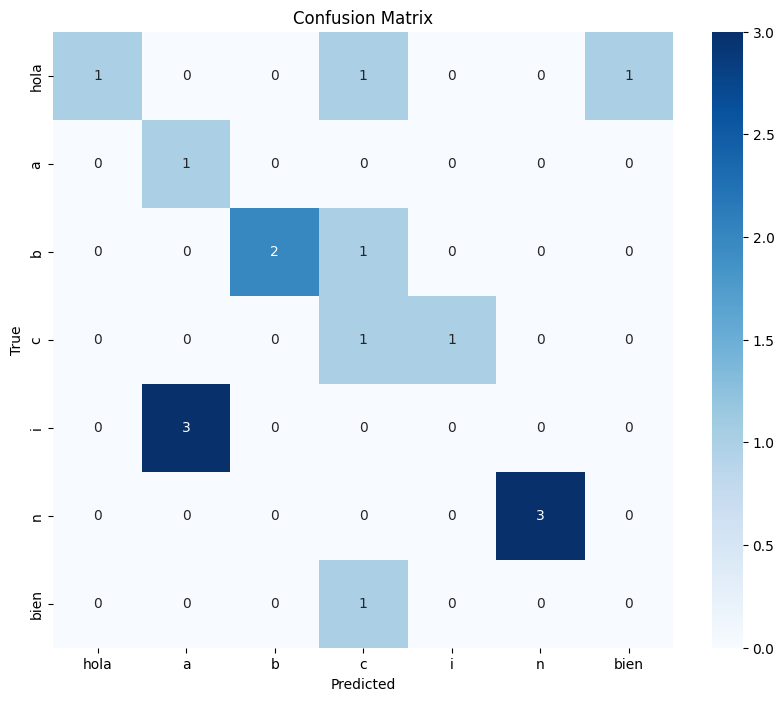

In [9]:
best_model = tf.keras.models.load_model('my_model_manos16.keras')
show_cm(X_val, y_val, best_model)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


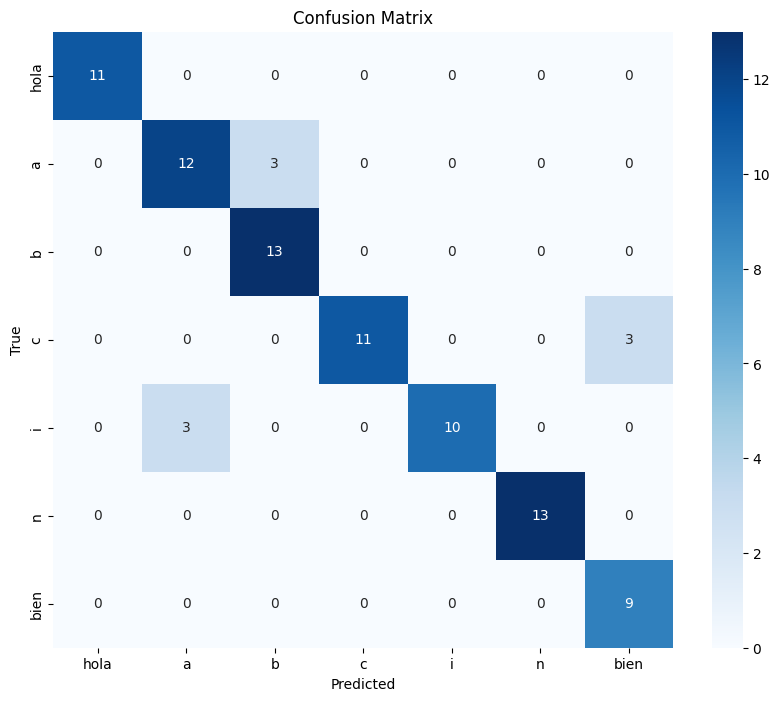

In [10]:
show_cm(X, y, best_model)